In [1]:
import os
import random
import shutil
import time
import warnings

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

In [2]:
SEED=1

In [3]:
random.seed(SEED)
torch.manual_seed(SEED)
cudnn.deterministic = True

In [4]:
START_EPOCH = 0

### Set the architecture to resnet 18 below

In [73]:
##########################
ARCH = 'resnet18'# set the architecture to RESNET 18
# please look up how to do that
########################
EPOCHS = 20
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
PRINT_FREQ = 50
TRAIN_BATCH=128
VAL_BATCH=128
WORKERS=2

### Check if cuda is available here

In [74]:
# check if cuda is available in this cell
# if it is not available, you should not go forward!
print("CUDA is available:", torch.cuda.is_available())

CUDA is available: True


### Assign your GPU below

In [75]:
# Assign your GPU in this cell
GPU = None

In [76]:
# set your active device to your GPU in this cell
device = torch.device("cuda")

In [77]:
# enable algorithm optimization
cudnn.benchmark = True

### Fill in the heart of the train section below

In [78]:
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch))

    ######################
    # switch model to train mode here
    model.train()
    ################

    end = time.time()
    for i, (images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        #####################
        # send the images to cuda device
        images = images.to(device)
        # send the target to cuda device
        target = target.to(device)

        # compute output
        output = model(images)

        # compute loss 
        loss = criterion(output, target)


        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        # compute gradient and do SGD step
        
        #### zero out gradients in the optimier
        optimizer.zero_grad()
        
        ## backprop!
        loss.backward()
        
        # update the weights!
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % PRINT_FREQ == 0:
            progress.display(i)

#### Fill in the validate section below

In [112]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            
            
            ### send the images and target to cuda
            images = images.cuda()
            target = target.cuda()

            # compute output
            output = model(images)

            # compute loss
            loss = criterion(output, target)


            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % PRINT_FREQ == 0:
                progress.display(i)

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
              .format(top1=top1, top5=top5))

    return [top1.avg, loss]

### Save the checkpoint

In [80]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    # save the model state!
    torch.save(state, filename)
    
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [81]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [82]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [83]:
# if we are adjusting the LR manually use this
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = LR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [84]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [85]:
cifar_mean_RGB = [0.4914, 0.4822, 0.4465]
cifar_std_RGB = [0.2023, 0.1994, 0.2010]

In [86]:
normalize = transforms.Normalize(mean=cifar_mean_RGB, std=cifar_std_RGB)

In [87]:
IMG_SIZE = 32
# IMG_SIZE = 224

### Initialize the model using the architecture you selected above

In [88]:
# select the model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Send the model to the cuda device

In [89]:
# send the model to the cuda device.. 
model = model.to(device)

### Instantiate the loss to cross entropy

In [90]:
# use the cross-entropy loss
criterion = nn.CrossEntropyLoss()

### Instantiate the optimizer to SGD

In [91]:
# use SGD .. use the momentum and weight decay vars
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

#### Create the learning rate scheduler

In [92]:
# use CosineAnnealingLR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=0.00001)

In [93]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean_RGB, cifar_std_RGB),
])

### Create the train dataset object

In [94]:
# use torchvision.datasets.CIFAR10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


In [95]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_mean_RGB, cifar_std_RGB),
])

### Create the val dataset object

In [96]:
# use torchvision.datasets.CIFAR10
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val)

Files already downloaded and verified


### Create the train dataloader

In [97]:
# fill this in
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH, shuffle=True, num_workers=WORKERS)

### Create the c

In [98]:
# fill this in..
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH, shuffle=False, num_workers=WORKERS)

In [99]:
best_acc1 = 0

In [113]:
EPOCHS = 20
epochs = []
results = []
for epoch in range(START_EPOCH, EPOCHS):
#    adjust_learning_rate(optimizer, epoch)

    # train for one epoch
    train(train_loader, model, criterion, optimizer, epoch)

    # evaluate on validation set
    val = validate(val_loader, model, criterion)
    acc1 = val[0]

    # remember best acc@1 and save checkpoint
    is_best = acc1 > best_acc1
    best_acc1 = max(acc1, best_acc1)


    save_checkpoint({
        'epoch': epoch + 1,
        'arch': ARCH,
        'state_dict': model.state_dict(),
        'best_acc1': best_acc1,
        'optimizer' : optimizer.state_dict(),
    }, is_best)

    # save Acc@1 as array for each epoc
    epochs.append(epoch)
    results.append(val[1].item())
    
    scheduler.step()
    print('lr: ' + str(scheduler.get_last_lr()))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc8c5eea550>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc8c5eea550>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a c

Epoch: [0][  0/391]	Time  0.755 ( 0.755)	Data  0.711 ( 0.711)	Loss 9.3811e-01 (9.3811e-01)	Acc@1  66.41 ( 66.41)	Acc@5  98.44 ( 98.44)
Epoch: [0][ 50/391]	Time  0.185 ( 0.095)	Data  0.103 ( 0.054)	Loss 7.8098e-01 (8.4166e-01)	Acc@1  71.09 ( 70.48)	Acc@5  98.44 ( 98.09)
Epoch: [0][100/391]	Time  0.046 ( 0.074)	Data  0.011 ( 0.037)	Loss 9.4617e-01 (8.3165e-01)	Acc@1  68.75 ( 70.98)	Acc@5  98.44 ( 98.00)
Epoch: [0][150/391]	Time  0.040 ( 0.068)	Data  0.007 ( 0.031)	Loss 9.8807e-01 (8.3800e-01)	Acc@1  63.28 ( 70.75)	Acc@5  97.66 ( 97.84)
Epoch: [0][200/391]	Time  0.042 ( 0.064)	Data  0.008 ( 0.028)	Loss 1.0130e+00 (8.4537e-01)	Acc@1  64.84 ( 70.57)	Acc@5  97.66 ( 97.79)
Epoch: [0][250/391]	Time  0.031 ( 0.067)	Data  0.001 ( 0.030)	Loss 6.8106e-01 (8.4047e-01)	Acc@1  74.22 ( 70.67)	Acc@5  99.22 ( 97.82)
Epoch: [0][300/391]	Time  0.056 ( 0.064)	Data  0.019 ( 0.028)	Loss 7.5024e-01 (8.4501e-01)	Acc@1  74.22 ( 70.52)	Acc@5  99.22 ( 97.79)
Epoch: [0][350/391]	Time  0.066 ( 0.063)	Data  0.037 ( 

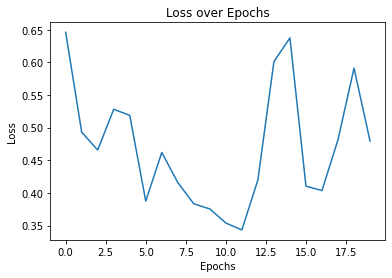

In [115]:
#display the loss over epoch
import matplotlib.pyplot as plt

plt.plot(epochs, results)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

The loss still fluctuates a lot but looks like it has a general trend downards to about 11 epochs and then jumps and needs to come down again. If we were to run for 200 epochs, we would likely see better convergence. 